In [118]:
import sys
# sys.path.append('/content/eth-capstone-treewater-deficit/src')
# sys.path.append('/home/renku/work/eth-capstone-treewater-deficit/src')
sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
import os
import glob 
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import collections

from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


from sklearn.preprocessing import StandardScaler
import treewater.utils as utils
# from treewater.utils import *

In [119]:

import importlib
importlib.reload(utils)

# check presence

print(hasattr(utils, "compute_recursive_predictions_fast_torch"))

True


In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [121]:
# set global random seed
seed = 66666
torch.manual_seed(seed)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # suppress INFO + WARNING

In [122]:
# derived_path = "/home/renku/work/eth-capstone-treewater-deficit/data"
# data_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/tstoy04"
# model_output_dir = "/home/renku/work/eth-capstone-treewater-deficit/data/derived/model_outputs/"

# derived_path = "/content/eth-capstone-treewater-deficit/data"
# data_dir = "/content/eth-capstone-treewater-deficit/data/tstoy04"

# model_output_dir = '/content/eth-capstone-treewater-deficit/data/derived/model_outputs/'

derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
model_output_dir = '/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/model_outputs/'

In [123]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [124]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [125]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [126]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [127]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [128]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

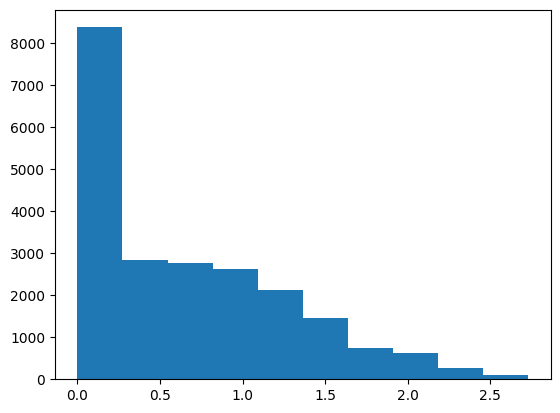

In [129]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [130]:
# Configure features

config = utils.FeatureConfig()
lag_n = 7 # use 7 and smaller model size 
label_window_size = 7

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = utils.create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n,
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = utils.standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = utils.get_dataset_NN_torch(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = utils.get_dataset_NN_torch(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)


In [131]:
val_y_at.shape

torch.Size([3140, 7])

In [132]:
val_X_ts_at.shape
val_y_at.shape

val_static_X_ts_at.shape
val_day_feat_X_at.shape

torch.Size([3140, 6])

In [133]:
batch_size = 128
lag_n = lag_n


### Autoregressive

In [134]:
# building datasets
batch_size = batch_size
# train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at

# ensure tensors are on CPU for DataLoader
if train_X_ts_at.device.type == "cuda":
    train_X_ts_at = train_X_ts_at.cpu(); train_day_feat_X_at = train_day_feat_X_at.cpu(); train_static_X_ts_at = train_static_X_ts_at.cpu(); train_y_at = train_y_at.cpu()
train_ds = TensorDataset(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, train_y_at)
train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=torch.cuda.is_available(),
                          num_workers=4)

# validation dataset

if val_X_ts_at.device.type == "cuda":
    val_X_ts_at = val_X_ts_at.cpu(); val_day_feat_X_at = val_day_feat_X_at.cpu(); val_static_X_ts_at = val_static_X_ts_at.cpu(); val_y_at = val_y_at.cpu()

val_loader = DataLoader(TensorDataset(val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at),
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=2)


# create cross validate datasets 
# create cross validation dataframes 

train_val_datasets_at = utils.cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df, val_cv_df in train_val_datasets_at:
    X_tr, Xd_tr, Xs_tr, y_tr = utils.get_dataset_NN_torch(train_cv_df, feature_window_size=lag_n, autoregressive=True, 
                                                            label_window_size = label_window_size,
                                                            config=config)
    if X_tr.device.type == "cuda":
        X_tr = X_tr.cpu(); Xd_tr = Xd_tr.cpu(); Xs_tr = Xs_tr.cpu(); y_tr = y_tr.cpu()
    tr_loader = DataLoader(TensorDataset(X_tr, Xd_tr, Xs_tr, y_tr),
                           batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())

    X_va, Xd_va, Xs_va, y_va = utils.get_dataset_NN_torch(val_cv_df, feature_window_size=lag_n, 
                                                           label_window_size = label_window_size,
                                                           autoregressive=True, config=config)
    if X_va.device.type == "cuda":
        X_va = X_va.cpu(); Xd_va = Xd_va.cpu(); Xs_va = Xs_va.cpu(); y_va = y_va.cpu()
    va_loader = DataLoader(TensorDataset(X_va, Xd_va, Xs_va, y_va),
                           batch_size=batch_size, shuffle=False, pin_memory=torch.cuda.is_available())

    cv_train_val_ds_at.append((tr_loader, va_loader))


### Build transformer architecture

In [135]:
# defined weighted MAE loss function with weight decay exponentially
def index_weighted_mae_exp_torch(H, decay=0.2):
    weights = torch.exp(-decay * torch.arange(H, dtype=torch.float32))
    weights = weights / weights.sum()

    def loss(y_pred, y_true):
        w = weights.to(y_pred.device, dtype=y_pred.dtype)
        return torch.mean(torch.sum(torch.abs(y_true - y_pred) * w, dim=1))
        #        ↑ sum over horizon, mean over batch
    return loss # do batch mean after summing over horizon


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d_model)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)

class EncoderOnlyForecast(nn.Module):
    """
    Uses TransformerEncoderLayer + TransformerEncoder as the core architecture.
    Inputs:
      past_dynamic: (B, T, n_dyn)
      current_day_exog: (B, n_day)
      static: (B, n_static)
    Output:
      next-day twd: (B,)
    """
    def __init__(
        self,
        n_dyn: int,
        n_day: int,
        n_static: int,
        T: int = 13,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 3,
        dim_feedforward: int = 32,
        dim_output: int = 7,
        dropout: float = 0.1,
        out_nonneg: bool = False,
    ):
        super().__init__()
        self.T = T
        self.out_nonneg = out_nonneg

        # project dynamic features -> d_model
        self.in_proj = nn.Linear(n_dyn, d_model)
        self.pos = PositionalEncoding(d_model, max_len=max(T, 64))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # IMPORTANT: we use (B, T, C)
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # combine with day exog + static
        self.day_mlp = nn.Sequential(
            nn.Linear(n_day, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.static_mlp = nn.Sequential(
            nn.Linear(n_static, 4),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(d_model + 4 + 4, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, out_features=dim_output),
        )

    def forward(self, past_dynamic, current_day_exog, static):
        # past_dynamic: (B, T, n_dyn)
        x = self.in_proj(past_dynamic)   # (B, T, d_model)
        x = self.pos(x)
        x = self.encoder(x)              # (B, T, d_model)

        # pool: last token (works well for fixed window)
        x_seq = x[:, -1, :]              # (B, d_model)

        x_day = self.day_mlp(current_day_exog)
        x_stat = self.static_mlp(static)

        z = torch.cat([x_seq, x_day, x_stat], dim=-1)
        y = self.head(z)

        if self.out_nonneg:
            y = F.linear(y) # using linear to allow negative outputs for log2 twd

        return y


In [136]:
# F.mse_loss(torch.tensor([1,2,3,4]), torch.tensor([1,2,3,5]), reduction='mean')

a = torch.tensor([[1,2,3,4], [1,2,4,4]]).float()
b = torch.tensor([[1,2,3,5], [1,2,3,5]]).float()
# F.mse_loss(a, b, reduction = "sum")

### set up cross validation

In [ ]:
model_factory = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=32,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dim_output = label_window_size,
            dropout=0.1,
            out_nonneg=False
        ).to(device)

# build a training loop

loss_fn = index_weighted_mae_exp_torch(H=label_window_size, decay=0.2)
optimizer = torch.optim.Adam(model_factory().parameters(), lr=1e-3/2)

rmses_cv_horizon, r2s_cv_horizon, y_trues_cv_horizon, y_preds_cv_horizon, historys_cv_horizon = utils.cross_validate_transformer_horizon(
    model_factory=model_factory,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


model_factory_2 = lambda : EncoderOnlyForecast(
            n_dyn=train_X_ts_at.shape[2],
            n_day=train_day_feat_X_at.shape[1],
            n_static=train_static_X_ts_at.shape[1],
            T=lag_n,
            d_model=64,
            nhead=4,
            num_layers=3,
            dim_feedforward=32,
            dim_output = label_window_size,
            dropout=0.1,
            out_nonneg=False
        ).to(device)


rmses_cv_horizon_2, r2s_cv_horizon_2, y_trues_cv_horizon_2, y_preds_cv_horizon_2, historys_cv_horizon_2 = utils.cross_validate_transformer_horizon(
    model_factory=model_factory_2,
    cv_train_val_ds_at=cv_train_val_ds_at,
    train_val_datasets_at=train_val_datasets_at,
    loss_fn=loss_fn,
    optimizer_class = torch.optim.Adam,
    config = config,
    lag_n = lag_n,
    batch_size = batch_size,
    lr=1e-3/2,
    n_epochs=50,
    device = device,
    if_log = True
)


/cluster/home/taoj/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Starting fold 1/4
Epoch 1/50
Train Loss: 0.5078, Train RMSE: 0.7112
Validation Loss: 0.5643, Validation RMSE: 0.7394
Epoch 2/50
Train Loss: 0.3363, Train RMSE: 0.4631
Validation Loss: 0.4413, Validation RMSE: 0.6418
Epoch 3/50
Train Loss: 0.2715, Train RMSE: 0.3913
Validation Loss: 0.4033, Validation RMSE: 0.5821
Epoch 4/50
Train Loss: 0.2490, Train RMSE: 0.3673
Validation Loss: 0.4131, Validation RMSE: 0.5905
Epoch 5/50
Train Loss: 0.2425, Train RMSE: 0.3518
Validation Loss: 0.4222, Validation RMSE: 0.6049
Epoch 6/50
Train Loss: 0.2355, Train RMSE: 0.3451
Validation Loss: 0.4147, Validation RMSE: 0.5970
Epoch 7/50
Train Loss: 0.2248, Train RMSE: 0.3355
Validation Loss: 0.4261, Validation RMSE: 0.6156
Epoch 8/50
Train Loss: 0.2265, Train RMSE: 0.3343
Validation Loss: 0.4016, Validation RMSE: 0.5881
Epoch 9/50
Train Loss: 0.2152, Train RMSE: 0.3283
Validation Loss: 0.3934, Validation RMSE: 0.5762
Epoch 10/50
Train Loss: 0.2170, Train RMSE: 0.3268
Validation Loss: 0.4124, Validation RMSE

/cluster/home/taoj/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train Loss: 0.4075, Train RMSE: 0.5778
Validation Loss: 0.3226, Validation RMSE: 0.4477
Epoch 2/50
Train Loss: 0.2690, Train RMSE: 0.3911
Validation Loss: 0.2827, Validation RMSE: 0.3967
Epoch 3/50
Train Loss: 0.2519, Train RMSE: 0.3766
Validation Loss: 0.2691, Validation RMSE: 0.3859
Epoch 4/50
Train Loss: 0.2389, Train RMSE: 0.3667
Validation Loss: 0.2644, Validation RMSE: 0.3824
Epoch 5/50
Train Loss: 0.2308, Train RMSE: 0.3598
Validation Loss: 0.2613, Validation RMSE: 0.3813
Epoch 6/50
Train Loss: 0.2252, Train RMSE: 0.3535
Validation Loss: 0.2569, Validation RMSE: 0.3779
Epoch 7/50
Train Loss: 0.2210, Train RMSE: 0.3487
Validation Loss: 0.2617, Validation RMSE: 0.3868
Epoch 8/50
Train Loss: 0.2164, Train RMSE: 0.3438
Validation Loss: 0.2477, Validation RMSE: 0.3772
Epoch 9/50
Train Loss: 0.2134, Train RMSE: 0.3393
Validation Loss: 0.2550, Validation RMSE: 0.3806
Epoch 10/50
Train Loss: 0.2090, Train RMSE: 0.3336
Validation Loss: 0.2480, Validation RMSE: 0.3741
Epoch 11/50
Train Lo

/cluster/home/taoj/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Train Loss: 0.4200, Train RMSE: 0.5832
Validation Loss: 0.2437, Validation RMSE: 0.3581
Epoch 2/50
Train Loss: 0.2646, Train RMSE: 0.3912
Validation Loss: 0.2090, Validation RMSE: 0.3350
Epoch 3/50
Train Loss: 0.2479, Train RMSE: 0.3781
Validation Loss: 0.1963, Validation RMSE: 0.3282
Epoch 4/50
Train Loss: 0.2394, Train RMSE: 0.3699
Validation Loss: 0.1883, Validation RMSE: 0.3241
Epoch 5/50
Train Loss: 0.2294, Train RMSE: 0.3612
Validation Loss: 0.1910, Validation RMSE: 0.3338
Epoch 6/50
Train Loss: 0.2257, Train RMSE: 0.3594
Validation Loss: 0.1809, Validation RMSE: 0.3198
Epoch 7/50
Train Loss: 0.2214, Train RMSE: 0.3559
Validation Loss: 0.1836, Validation RMSE: 0.3187
Epoch 8/50
Train Loss: 0.2189, Train RMSE: 0.3530
Validation Loss: 0.1817, Validation RMSE: 0.3179
Epoch 9/50
Train Loss: 0.2154, Train RMSE: 0.3499
Validation Loss: 0.1739, Validation RMSE: 0.3112
Epoch 10/50
Train Loss: 0.2141, Train RMSE: 0.3484
Validation Loss: 0.1811, Validation RMSE: 0.3135
Epoch 11/50
Train Lo

In [ ]:
# model_fold = model_factory().to(device) if device else model_factory()
# model_fold(val_X_ts_at[1, ],  val_day_feat_X_at[2, ], val_static_X_ts_at[3, ])

In [146]:
def unnest_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

df_cv_results_horizon = pd.DataFrame({
    'model_size': ['32']*4*7 + ['64']*4*7,
    'cv_fold': [i for i in range(1, 5) for _ in range(7)] * 2,
    'horizon': list(range(1,8))*4*2,
    'rmse': unnest_list(rmses_cv_horizon) + unnest_list(rmses_cv_horizon_2),
    'r2': unnest_list(r2s_cv_horizon) + unnest_list(r2s_cv_horizon_2)})

/scratch/tmp.55068978.taoj/ipykernel_239136/3819283496.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(df_cv_results_horizon, x="horizon", y="rmse", hue="model_size", palette = "Set2",
/scratch/tmp.55068978.taoj/ipykernel_239136/3819283496.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax2 = sns.barplot(df_cv_results_horizon, x="horizon", y="r2", hue="model_size", palette = "Set2",


Text(0.5, 1.0, 'R2 vs Horizon')

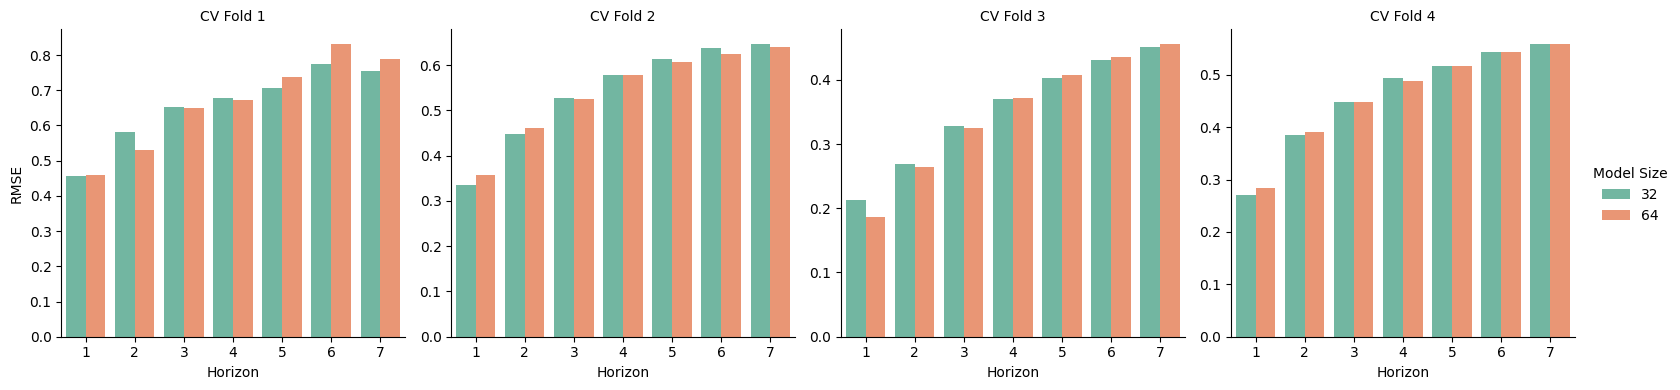

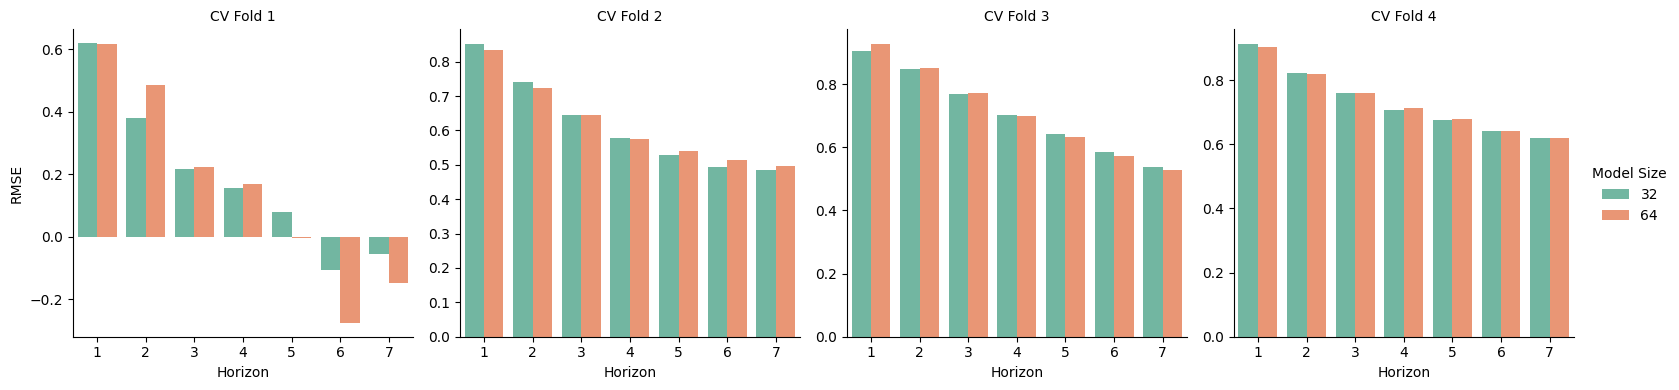

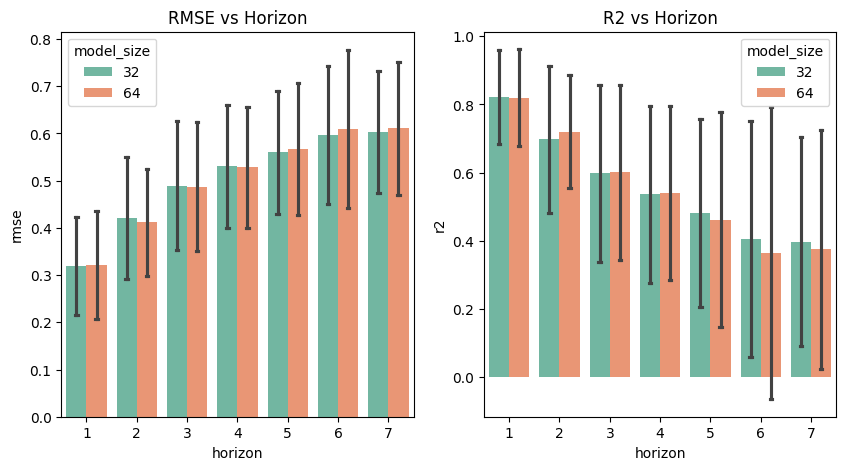

In [147]:

g = sns.FacetGrid(df_cv_results_horizon, col="cv_fold", col_wrap = 4,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="horizon",
    y="rmse",
    hue = 'model_size',
    palette = "Set2",
    legend = True,
)
g.add_legend(title='Model Size')
g.set_axis_labels("Horizon", "RMSE")
g.set_titles(col_template="CV Fold {col_name}")


g_r = sns.FacetGrid(df_cv_results_horizon, col="cv_fold", col_wrap = 4,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="horizon",
    y="r2",
    hue = 'model_size',
    palette = "Set2",
    legend = True,
)
g_r.add_legend(title='Model Size')
g_r.set_axis_labels("Horizon", "RMSE")
g_r.set_titles(col_template="CV Fold {col_name}")

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax = sns.barplot(df_cv_results_horizon, x="horizon", y="rmse", hue="model_size", palette = "Set2",
                 ci="sd", capsize=0.1, ax=ax)

ax2 = sns.barplot(df_cv_results_horizon, x="horizon", y="r2", hue="model_size", palette = "Set2",
                 ci="sd", capsize=0.1, ax=ax2)
ax.set_title("RMSE vs Horizon")
ax2.set_title("R2 vs Horizon")


maybe test different model size?

In [ ]:
model_ar = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=64, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=64, # dimension of feedforward network,
    dim_output = label_window_size,
    dropout=0.1,
    out_nonneg=False
).to(device)

loss_fn = index_weighted_mae_exp_torch(H=label_window_size, decay=0.2)
optimizer = torch.optim.Adam(model_ar.parameters(), lr=1e-3/2)


# writer = SummaryWriter(os.path.join(model_output_dir, f'transformer_ar{timestamp}'))
epoch_number = 0


history = {"train_loss": [], "train_rmse": [], "val_loss": [], "val_rmse": [],
           "p_tf": []}
best_vloss = float("inf")

EPOCHS = 80

best_vloss = 1_000_000.


for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ar.train(True)
    avg_loss, train_rmse = utils.train_one_epoch(model_ar, epoch_number, train_loader, loss_fn, optimizer,
                                           device=device, log_every=100)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model_ar.eval()
    val_sse = 0.0
    val_n = 0   
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
            voutputs = model_ar(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
            vloss = loss_fn(voutputs, vlabels.to(device))
            running_vloss += vloss
            val_sse += F.mse_loss(voutputs, vlabels.to(device), reduction='mean').item() * vlabels.numel()
            val_n += vlabels.numel()



    avg_vloss = running_vloss / (i + 1)
    avg_vloss_f = avg_vloss.item() if hasattr(avg_vloss, "item") else float(avg_vloss)

    val_rmse = math.sqrt(val_sse / val_n) if val_n > 0 else float("nan")
    print(f'Train loss:{avg_loss:.4f}, Train RMSE:{train_rmse:.4f}, Val loss:{avg_vloss:.4f}, Val RMSE:{val_rmse:.4f}')
    # Log the running loss averaged per batch
    # for both training and validation

    history["train_loss"].append(float(avg_loss))
    history["val_loss"].append(avg_vloss_f)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_rmse)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(model_output_dir, f'model_{epoch_number}')
        torch.save(model_ar.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


/cluster/home/taoj/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  batch 100 loss: 0.3059


KeyboardInterrupt: 

In [148]:
model_path 

'/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data/derived/model_outputs/model_20'

In [149]:
model_ar.eval()
model_ar(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device)).shape

torch.Size([68, 7])

In [164]:
# predction on validation set
model_ar.eval()
model_best = EncoderOnlyForecast(
    n_dyn=train_X_ts_at.shape[2],
    n_day=train_day_feat_X_at.shape[1],
    n_static=train_static_X_ts_at.shape[1],
    T=lag_n,
    d_model=64, # embedding dimension
    nhead=4, # number of attention heads
    num_layers=3, # number of transformer layers
    dim_feedforward=64, # dimension of feedforward network,
    dim_output = label_window_size,
    dropout=0.1,
    out_nonneg=False
).to(device) # initiate a new model
model_best.load_state_dict(torch.load(model_path))
preds = []
actuals = []
with torch.no_grad():
    for i, (X_dyn_val, X_day_val, X_static_val, vlabels) in enumerate(val_loader):
        voutputs = model_best(X_dyn_val.to(device), X_day_val.to(device), X_static_val.to(device))
        preds.append(voutputs.cpu().numpy())
        actuals.append(vlabels.cpu().numpy())

preds = np.concatenate(preds, axis=0)
actuals = np.concatenate(actuals, axis=0)

preds = utils.clip_and_inverse_log2_transform(preds)
actuals = utils.clip_and_inverse_log2_transform(actuals)

rmses_cv_horizon_val = [root_mean_squared_error(actuals[:, i],preds[:, i]) for i in range(0, actuals.shape[1])]
r2s_cv_horizon_val= [r2_score(actuals[:, i],preds[:, i]) for i in range(0, actuals.shape[1])]

/cluster/home/taoj/env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


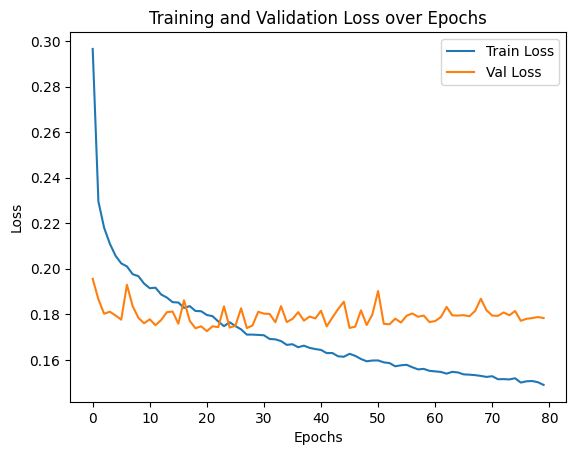

In [165]:
plt.plot(range(0, EPOCHS), history["train_loss"], label="Train Loss")
plt.plot(range(0, EPOCHS), history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()

Text(4, 5.1, 'R2:0.498')

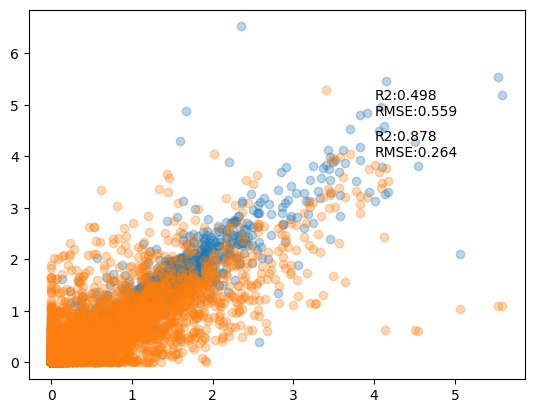

In [167]:
# next day prediction performance

plt.scatter(actuals[:, 0], preds[:, 0], alpha=0.3)
plt.scatter(actuals[:, 6], preds[:, 6], alpha=0.3)

plt.text(x=4, y = 4, s = f"RMSE:{rmses_cv_horizon_val[0]:.3f}")
plt.text(x= 4, y = 4.3, s=f"R2:{r2s_cv_horizon_val[0]:.3f}")

plt.text(x=4, y = 4.8, s = f"RMSE:{rmses_cv_horizon_val[6]:.3f}")
plt.text(x= 4, y = 5.1, s=f"R2:{r2s_cv_horizon_val[6]:.3f}")

In [ ]:
print()

- performance appears more stable when model size is 64

trained with logged values

why the performance is so bad ..
- try the same on ridge regression?
- pick the best model in different training strategy?